# EDA and Visualization Final Project: Data Prep and Analysis
## Zachary Barnes and Bing Wang

##### Housekeeping

In [1]:
# Load Python libraries
import os
import numpy as np
import pandas as pd

# Run R code adjacent to Python code
%load_ext rpy2.ipython

# Load ggplot R library
%R library(ggplot2)
%R library(scales)

# Avoid kernal death
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Read in and organize data (Collisions and Victims datasets, from TIMS)

In [2]:
c = pd.read_csv("Collisions.csv")

# Keep only relevant columns
c = c[['CASE_ID','COLLISION_DATE','COLLISION_TIME','INTERSECTION','COLLISION_SEVERITY',
        'LIGHTING','LOCATION_TYPE','MVIW','TYPE_OF_COLLISION',
        'WEATHER_1','LATITUDE','LONGITUDE','PRIMARY_RD',
        'SECONDARY_RD','POINT_X','POINT_Y']]
# Convert COLLISION_TIME to hour of day (use tlater to match speeds to collisions)
c['COLLISION_TIME'] = [int(i[:-2]) if len(i) > 2 else 0 for i in c['COLLISION_TIME'].astype(str).values]

# Make Collision_Date a DateTime object
c["COLLISION_DATE"] = pd.to_datetime(c.COLLISION_DATE)

# Add quarter column (use later in match speeds to collisions)
c['QUARTER'] = c['COLLISION_DATE'].map(pd.to_datetime).dt.quarter

print(len(c))
c.sample(5)

3870


,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,MVIW,TYPE_OF_COLLISION,WEATHER_1,LATITUDE,LONGITUDE,PRIMARY_RD,SECONDARY_RD,POINT_X,POINT_Y,QUARTER
3863,90900760,2018-12-18,17,N,3,C,NaN,C,C,A,37.71069,-122.45764,I-280 S/B,SAN JOSE AVE UNDERCROSSING,-122.457636,37.710615,4
3806,90882066,2018-12-04,6,N,4,A,NaN,C,C,B,37.74295,-122.40657,US-101 S/B,CORTLAND AVE,-122.406622,37.742994,4
1066,8745191,2018-10-05,14,N,4,A,NaN,C,C,A,NaN,NaN,PARK PRESIDIO BL,CLEMENT ST,-122.472412,37.781757,4
1431,8699708,2018-08-30,18,N,3,A,NaN,-,A,A,NaN,NaN,EMBARCADERO ST,BRANNAN ST,NaN,NaN,3
2463,8620670,2018-04-23,7,N,4,A,NaN,C,C,A,NaN,NaN,BRYANT ST,15TH ST,-122.410597,37.766618,2


In [3]:
v = pd.read_csv('Victims.csv')

# Keep only relevant columns
v = v[['CASE_ID','VICTIM_DEGREE_OF_INJURY','VICTIM_ROLE','VICTIM_AGE']]

# Keep only fatalities and severe injuries (Victim_Degree_of_Injury = 1 or 2)
v = v.loc[v.VICTIM_DEGREE_OF_INJURY.isin([1, 2])]

print(len(v))
v.sample(5)

289


,CASE_ID,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE
3915,8597251,2,1,67
659,8758229,2,3,37
754,8758149,2,3,44
1878,8698217,2,2,27
2941,8649623,2,4,56


In [46]:
# Merge Collisions and Victims datasets
cv = pd.merge(c, v, how='left', on='CASE_ID')

print(len(cv))
print(cv.COLLISION_SEVERITY.value_counts())
print(cv.VICTIM_DEGREE_OF_INJURY.value_counts())
cv.head()

len(cv.loc[~(cv.VICTIM_DEGREE_OF_INJURY.isna())])

3882
4    2549
3    1014
2     294
1      25
Name: COLLISION_SEVERITY, dtype: int64
2.0    262
1.0     25
Name: VICTIM_DEGREE_OF_INJURY, dtype: int64


287

In [31]:
# Drop observations from highway, since Vision Zero does not cover highways
cv = cv.loc[cv.LOCATION_TYPE != "H"]
len(cv)

284

In [32]:
# Paul's Function to remove NaNs from columns
def fixDFcolsForR(myDF):
    for i in range(myDF.shape[1]): # for each col
        if myDF.iloc[:, i].dtype == 'O': # check if col is type object
            myDF.iloc[:, i] = myDF.iloc[:, i].astype(str) # if yes set type to string
    return myDF

In [33]:
# Convert NaNs to string type
cv = fixDFcolsForR(cv)
cv.sample(5)

,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,MVIW,TYPE_OF_COLLISION,WEATHER_1,LATITUDE,LONGITUDE,PRIMARY_RD,SECONDARY_RD,POINT_X,POINT_Y,QUARTER,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE
151,8648194,2018-08-14,17.0,Y,1.0,A,nan,G,D,B,NaN,NaN,TAYLOR ST,TURK ST,-122.410780,37.783210,3.0,1,4,65
83,8716516,2018-09-12,1.0,N,2.0,C,nan,I,E,A,NaN,NaN,PARK PRESIDIO BL,FULTON ST,-122.471780,37.773130,3.0,2,1,27
266,8552795,2018-01-09,6.0,Y,2.0,C,nan,B,G,A,NaN,NaN,DIVISION ST,POTRERO ST,-122.407880,37.769220,1.0,2,3,998
227,8594635,2018-03-03,15.0,N,2.0,A,nan,B,D,A,NaN,NaN,KIRKHAM ST,16TH AV,-122.473657,37.759970,1.0,2,3,25
225,8594810,2018-03-22,19.0,N,2.0,C,nan,B,G,A,NaN,NaN,JESSIE ST,6TH ST,-122.409200,37.781408,1.0,2,3,59


Now, we need to attach Open Street Maps (OSM) way IDs to each observation in the Collisions-Victims dataset, in order to match with the speed dataset. An OSM way ID is an ID that matches latitude and longitude to a street segment.

# Use Nominatim API to convert lat long to OSM ID

In [19]:
import requests
import json

def osmid(lat,lon):
    URL = 'https://nominatim.openstreetmap.org/reverse?format=json&lat=%s&lon=%s'
    r = requests.get(URL % (lat,lon))
    data = json.loads(r.text)
#     osm_id = data.get('osm_id','NONE')
    return data['osm_id']


This code snippet below creates osm.csv, a list of OSM IDS and their latitudes and longitudes. We will use this to attach OSM IDs to our Collisions-Victims dataset.

In [20]:
# import time
# lat_long = cv[['POINT_Y','POINT_X','VICTIM_DEGREE_OF_INJURY']]
# osm_id = list()
# for i,row in lat_long.iterrows():
#     if (np.isnan(row['POINT_Y']) or np.isnan(row['POINT_X'])) or np.isnan(row['VICTIM_DEGREE_OF_INJURY']):
#         osm_id.append('NONE')
#         continue
#     else:
#         time.sleep(2)
#         osm_id.append(osmid(row['POINT_Y'],row['POINT_X']))
# osm_series = pd.Series(osm_id)
# osm_series.to_csv('osm.csv')

# Add OSM_ID column 

In [34]:
# since we have preprocessed and saved OSM ID data, just read in as csv
osm = pd.read_csv('osm.csv',header=None)
osm.columns = ['index','OSM_ID']
cv['OSM_ID'] = osm['OSM_ID']

print(len(cv))
print(cv.OSM_ID.value_counts())
cv.sample(5)

284
NONE          278
2503369217      1
3802986672      1
27652378        1
148313526       1
27553863        1
467150002       1
Name: OSM_ID, dtype: int64


,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,MVIW,TYPE_OF_COLLISION,WEATHER_1,...,LONGITUDE,PRIMARY_RD,SECONDARY_RD,POINT_X,POINT_Y,QUARTER,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE,OSM_ID
67,8754675,2018-10-09,4.0,Y,2.0,C,nan,C,D,A,...,NaN,GEARY BL,FRANKLIN ST,-122.423020,37.785480,4.0,2,1,24,NONE
231,8594301,2018-03-26,11.0,N,2.0,A,nan,B,G,A,...,NaN,MARKET ST,4TH ST,-122.406300,37.785365,1.0,2,3,65,NONE
108,8690297,2018-05-28,13.0,N,2.0,A,nan,G,D,A,...,NaN,EVANS AV,SELBY ST,-122.393990,37.746130,2.0,2,4,50,NONE
178,8630659,2018-02-13,13.0,N,2.0,A,nan,B,G,A,...,-122.49411,SUNSET BL,WAWONA ST,-122.494132,37.736655,1.0,2,3,76,NONE
98,8698222,2018-08-02,12.0,Y,2.0,A,nan,B,A,A,...,NaN,17TH ST,VALENCIA ST,-122.421740,37.763300,3.0,2,3,50,NONE


# Load in Uber Speeds dataset

In [ ]:
avgspeeds = pd.read_csv('avgspeeds.csv')
avgspeeds.head()

In [35]:
# Reduce cv DataFrame to only entries with non-null Quarter, Collision_Time, and OSM_ID 
# before joining to avgspeeds
cvsmall = cv.loc[(~cv['QUARTER'].isna()) & (~cv['COLLISION_TIME'].isna()) & ~(cv['OSM_ID'] == 'NONE')]
#cvsmall['OSM_ID'] = cvsmall['OSM_ID'].astype(int)

# NOTE 10/1: Commented out as this resulting in error "AttributeError: 'int' object has no attribute 'encode'"

# There are 271 entries.
len(cv.loc[~(cv['OSM_ID'] == 'NONE')])

6

The code below produces speeds.csv, a subset of averagespeeds.csv. It reduces the speeds observations down to ones that would match the Collisions-Victims dataset on OSD_ID, Quarter, and Collision_Time. If there is no match, set speed = 0.

In [ ]:
# speeds = list()
# for i, row in cvsmall.iterrows():
#     speed = avgspeeds.loc[(avgspeeds['osm_way_id'] == row['OSM_ID']) & 
#               (avgspeeds['quarter'] == row['QUARTER']) & 
#               (avgspeeds['hour_of_day'] == row['COLLISION_TIME'])]['speed_mph_mean']
#     if speed.values.size > 0:
#          speeds.append(speed.values[0])
        
#     else:
#         speeds.append(0)
# speeds = pd.Series(speeds)
# speeds.to_csv('speeds.csv')


Now, we join cvsmall (the reduced Collisions-Victims dataset) to the speeds dataset.

In [ ]:
speeds = list(pd.read_csv("speeds.csv",header=None))
cvsmall["SPEEDS"] = speeds
print(len(speeds))

# Preliminary graphs (without speed or regressions)

In [ ]:
# fix NaNs with Paul's function before passing to R
cvsmall = fixDFcolsForR(cvsmall)

In [ ]:
cvsmall.dtypes

In [ ]:
# Add column of months for graphing time series
cvsmall["Month"] = cvsmall.COLLISION_DATE.dt.month

len(cvsmall)

# Aggregate up to month
#cvsmall_m = cvsmall.groupby(["VICTIM_DEGREE_OF_INJURY"]).count()
#cvsmall_m

In [ ]:
%R -i cvsmall
%R -i cvsmall_m

In [ ]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() + 
geom_line(aes(x = Month, y = )

In [76]:
# remove nonsensical/placeholder VICTIM_AGE (=998?)
v_cleanage = v.loc[v.VICTIM_AGE < 150]
v_cleanage = v_cleanage.groupby(["VICTIM_DEGREE_OF_INJURY", "VICTIM_AGE"]).count().reset_index()
v_cleanage.dtypes

VICTIM_DEGREE_OF_INJURY    int64
VICTIM_AGE                 int64
CASE_ID                    int64
VICTIM_ROLE                int64
dtype: object

In [64]:
%R -i v_cleanage

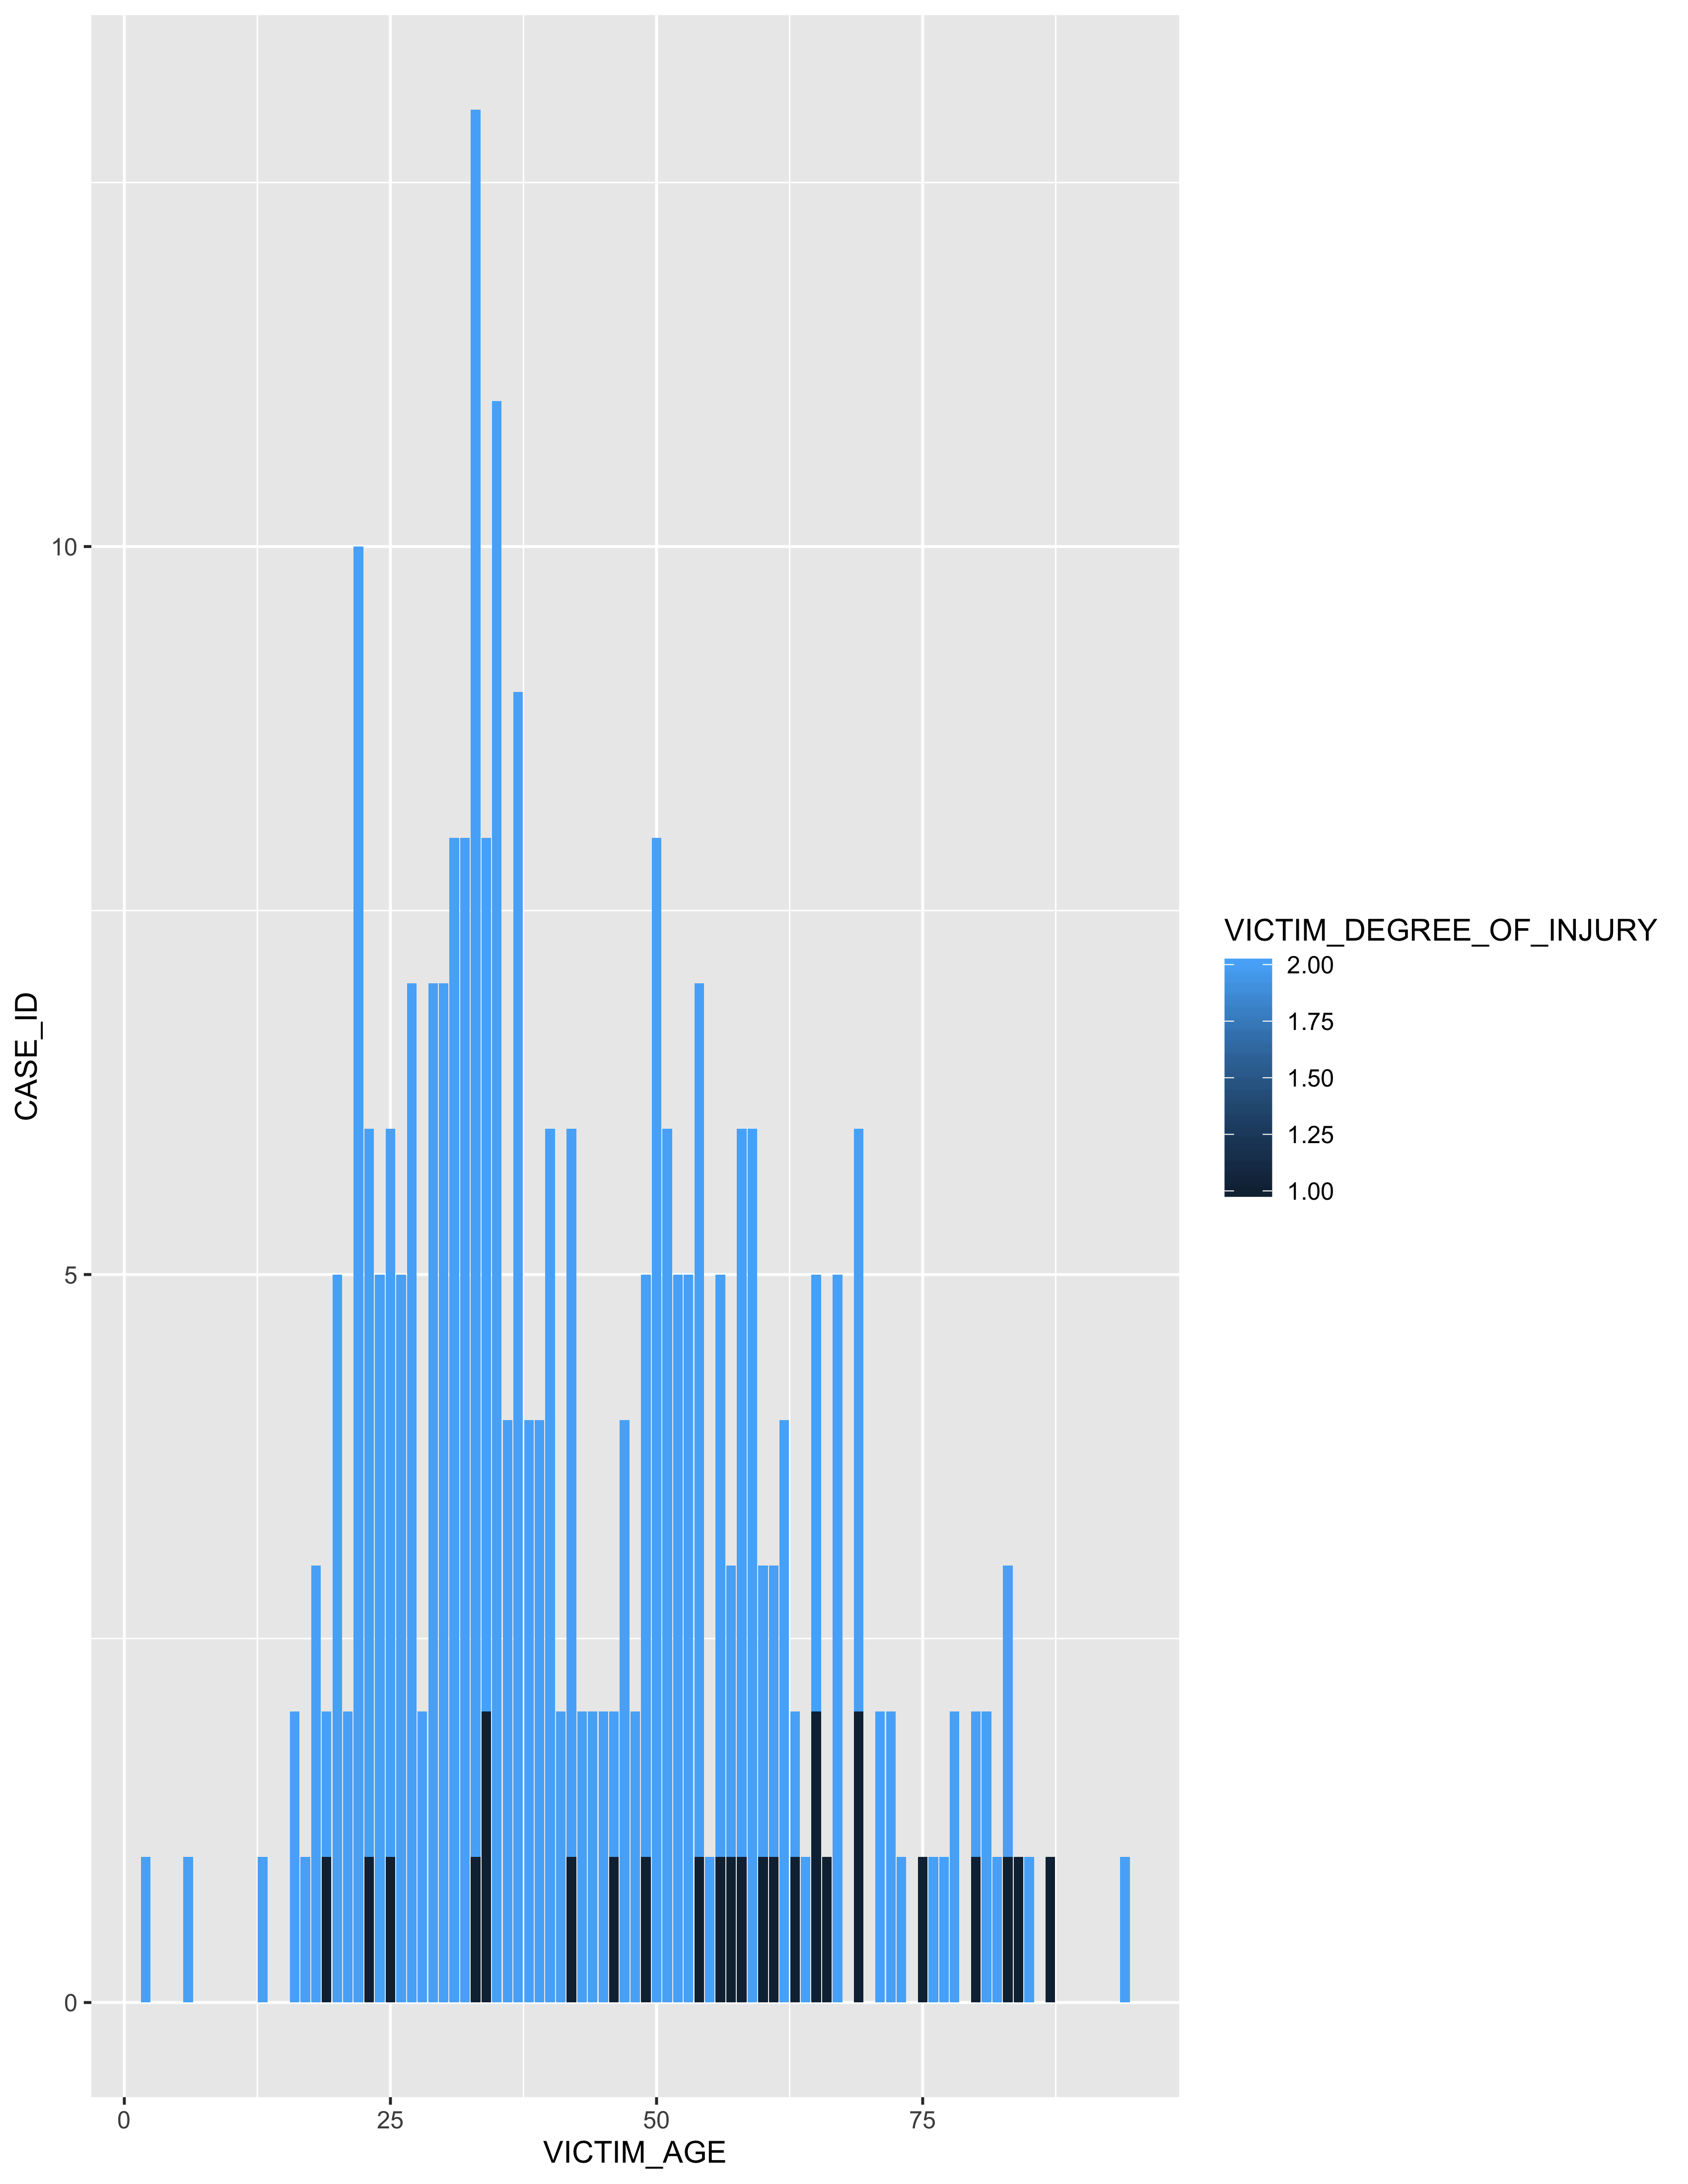

In [82]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() + 
geom_histogram(aes(x = VICTIM_AGE, y = CASE_ID, fill = VICTIM_DEGREE_OF_INJURY), data = v_cleanage, 
               stat = "identity", binwidth = 10)
